## 二段階最小二乗法の一段目をMLにする

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
%matplotlib inline

In [2]:
from numpy.random import *

In [58]:
seed(8492)

"""
サンプル生成用の関数
"""
def create_sample(n):
    #XとZを相関を持つように作る
    cX = multivariate_normal( [10,10],  [[10,8],[8,10]],  n)
    
    #誤差項
    eps = normal(0, 5, n)
#     eps2 = normal(0, 5, n)

    #観測不可能な交絡因子
    conf = normal(10, 5, n)

    #data for TSLS
    #交絡要因の影響は適当に入れている
    Z = cX[:,0]
    X = 5 + cX[:,1] + 0.3*conf
    y = 5 + 15*X + 0.4*conf + eps

    #data for OLS
    y_OLS = 5 + 15*X+ eps
    
    return y, X, Z, y_OLS


**急いで作ったので行列のshapeが怪しいので注意**

In [59]:
from sklearn import svm

# ndarrayに定数項用の列を追加
def add_const(X):
    r, c = X.shape
    nX = np.ones((r, c+1))
    nX[:,:-1] = X
    return nX
    
#TSLSを解く
def solve_TSLS(y, X, Z):
    coef = solve_OLS(X, Z)
    coef = coef[:, np.newaxis]
    Z = add_const(Z[:, np.newaxis])
    est = Z@coef
    est = add_const(est)
    return np.linalg.inv(est.T@est)@est.T@y

#OLSを解く
def solve_OLS(y, X):
    X = X[:, np.newaxis]
    X = add_const(X)
    ans = np.linalg.inv(X.T@X)@X.T@y
    return ans

#TSLSを解く、一段目がSVM
def solve_TSLS_ML(y, X, Z):
    clf = svm.SVR()
    Z = add_const(Z[:, np.newaxis])
    X = X[:, np.newaxis]
    clf.fit(Z, X)
    est = clf.predict(Z)[:,np.newaxis]
    est = add_const(est)
    return np.linalg.inv(est.T@est)@est.T@y

#test
df = pd.DataFrame(index=[], columns=["n", "OLS", "OLS with conf", "TSLS", "TSLS ML"])
#サンプルサイズを100から5000まで100ずつふやしながら予測してみる
i = 100
while i <= 3000:
    y,X,Z,y_OLS = create_sample(i)
    #ここ気持ち悪いことになってるごめん
    #X（shapeは(n,1)）の係数だけDFに入れている
    sr = pd.Series([i, solve_OLS(y_OLS, X)[0], solve_OLS(y, X)[0], solve_TSLS(y, X, Z)[0], solve_TSLS_ML(y, X, Z)[0]],index=["n", "OLS", "OLS with conf", "TSLS", "TSLS ML"])
    df = df.append(sr,ignore_index=True)
    print(i)
    i += 100


/Users/shiki/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


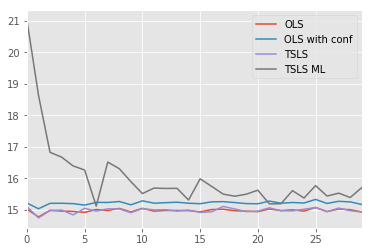

In [60]:
#plot
df[["OLS", "OLS with conf", "TSLS", "TSLS ML"]].plot()

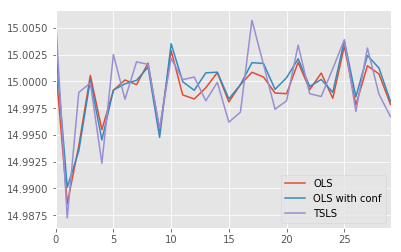

In [57]:
df[["OLS", "OLS with conf", "TSLS"]].plot()

## 操作変数が使えるのなら$\hat{X}$で予測するほうが、Xで予測するより良いのでは？

In [68]:
# sklearnで予測をしてみる
from sklearn import svm
from sklearn.model_selection import train_test_split
clf = svm.SVR()
# clf.fit(X, y) 
# clf.predict([[1, 1]])

n = 1000
y,X,Z,y_OLS = create_sample(n)
print(X.shape, y.shape, Z.shape, y_OLS.shape)
# X = X[:np.newaxis].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_OLS, test_size=0.25, random_state=8492)


print(X_train.shape, y_train.shape) 
# clf.fit(X_train, y_train) 
# while i <= 10000:

#     sr = pd.Series([i, solve_OLS(y_OLS, X)[0], solve_OLS(y, X)[0], solve_TSLS(y, X, Z)[0]],index=["n", "OLS", "OLS with conf", "TSLS"])
#     df = df.append(sr,ignore_index=True)
# #     print(df)
#     i += 100

(1000,) (1000,) (1000,) (1000,)
(750,) (750,)


In [17]:
a = clf.predict(X_test)
plt.plot(a, "o")
plt.plot(y_test, "bo")
plt.show()

NotFittedError: This SVR instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.